##  Credit Risk Modelling 

This notebook covers training and evaluating different models to predict loan defaults

In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from credit_risk_model.data_cleaning import clean_all
from credit_risk_model.feat_eng import engineer_features
from credit_risk_model.model import(
     train_logistic_regression,
     train_xgboost, train_lightgbm,
    compare_models,hyperparameter_tuning_xgboost, 
    hyperparameter_tuning_lightgbm,
    compare_tuned_and_baseline_models
)
import matplotlib.pyplot as plt
import seaborn as sns
from credit_risk_model.config import DATA_PROCESSED, MODELS_DIR, RESULTS_DIR

# Import necessary libraries for modelling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, 
    classification_report,
    confusion_matrix
)
import joblib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
df = pd.read_csv(DATA_PROCESSED/"agg_main.csv")

In [25]:
df.head()

,target,credit_income_ratio,total_income,total_credit_requested,monthly_loan_payment,value_of_goods_financed,age_years,employment_years,NAME_CONTRACT_TYPE,CODE_GENDER,...,avg_amt_credit,approval_rate,n_active_contracts,avg_months_active,n_completed_contracts,avg_payment_ratio,installments_n_late_payments,avg_balance,max_balance,avg_utilization
0,0,2.857143,157500.0,450000.0,35685.0,450000.0,59.309589,12.909589,Cash loans,F,...,443773.607143,0.428571,34.0,-34.794118,5.0,1.056709,2.0,29452.900500,158449.500,NaN
1,0,1.200000,112500.0,135000.0,7879.5,135000.0,48.030137,0.441096,Cash loans,F,...,170367.750000,0.750000,59.0,-26.881356,4.0,1.000000,0.0,0.000000,0.000,0.000000
2,0,6.040000,112500.0,679500.0,19867.5,679500.0,37.117808,5.468493,Cash loans,F,...,145647.750000,0.833333,35.0,-28.428571,3.0,0.897436,7.0,0.000000,0.000,0.000000
3,0,2.900000,225000.0,652500.0,47610.0,652500.0,38.049315,6.347945,Cash loans,M,...,167734.500000,1.000000,24.0,-29.000000,2.0,0.941860,3.0,279583.392414,463463.865,0.759396
4,0,0.733333,135000.0,99000.0,10395.0,99000.0,27.446575,1.038356,Cash loans,F,...,146957.785714,1.000000,49.0,-47.367347,4.0,0.979031,16.0,193191.533710,463813.695,0.674371


## split data

splitting is done so early here to avoid leakage of information from the validation set into the training process, since cleaning uses data level statistics 


In [26]:
# split
X = df.drop('target', axis=1)
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


## clean data

In [27]:
#clean data
X_train = clean_all(X_train)
X_val = clean_all(X_val)

## feature engineering

In [28]:
# feature engineering
X_train = engineer_features(X_train)
X_val = engineer_features(X_val)

# Replace infinity with nan
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)

#save feature names for streamlit app
feature_list = X_train.columns.tolist()
joblib.dump(feature_list, DATA_PROCESSED/"feature_list.joblib")

# save processed data
X_train.to_csv(DATA_PROCESSED/"feature_engineered.csv", index=False)
X_val.to_csv(DATA_PROCESSED/"feature_engineered_val.csv", index=False)
y_val.to_csv(DATA_PROCESSED/"target_val.csv", index=False)
y_train.to_csv(DATA_PROCESSED/"target_train.csv", index=False)

## Evaluate models 

### Baseline model (Logistic Regression)
scaling is done here on only the continuous cols ommiting encoded cols and binary cols

NOTE: tree based models don't require scaling, it is only done here for logistic regression

In [29]:
log_reg_pipe, y_proba, y_pred = train_logistic_regression(
    X_train, y_train, X_val
)

print("="*50)
print("BASELINE MODEL PERFORMANCE (Logistic Regression)")
print("="*50)

print(f"\nROC-AUC Score: {roc_auc_score(y_val, y_proba):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

BASELINE MODEL PERFORMANCE (Logistic Regression)

ROC-AUC Score: 0.6954

Confusion Matrix:
[[35952 20586]
 [ 1709  3256]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     56538
           1       0.14      0.66      0.23      4965

    accuracy                           0.64     61503
   macro avg       0.55      0.65      0.49     61503
weighted avg       0.89      0.64      0.72     61503



### XGBoost

In [30]:
xgb_model, y_proba_xgb, y_pred_xgb = train_xgboost(
    X_train, y_train, X_val
)

print("="*50)
print("XGBoost Performance")
print("="*50)
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_xgb):.4f}")
print("\n", classification_report(y_val, y_pred_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

XGBoost Performance
ROC-AUC: 0.7203

               precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.22      0.31      0.26      4965

    accuracy                           0.85     61503
   macro avg       0.58      0.61      0.59     61503
weighted avg       0.88      0.85      0.87     61503


Confusion Matrix:
[[51017  5521]
 [ 3408  1557]]


### Lightboost 

In [31]:
lgbm_model, y_proba_lgbm, y_pred_lgbm = train_lightgbm(
    X_train, y_train, X_val
)

print("="*50)
print("LightGBM Performance")
print("="*50)
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_lgbm):.4f}")
print("\n", classification_report(y_val, y_pred_lgbm))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_lgbm))

LightGBM Performance
ROC-AUC: 0.7209

               precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.22      0.32      0.26      4965

    accuracy                           0.86     61503
   macro avg       0.58      0.61      0.59     61503
weighted avg       0.88      0.86      0.87     61503


Confusion Matrix:
[[51072  5466]
 [ 3401  1564]]


### Compare results

In [35]:
results_df = compare_models(X_val, y_val, log_reg_pipe, xgb_model, lgbm_model)
results_df

,AUC-ROC,AUC-PR,Precision,Recall,F1-score,KS,Gini
LightGBM,0.720898,0.195083,0.222475,0.315005,0.260775,0.327960,0.441796
XGBoost,0.720327,0.195467,0.219977,0.313595,0.258573,0.329937,0.440654
LogisticRegression,0.695354,0.166413,0.081546,0.997986,0.150773,0.294968,0.390708


## Hyperparameter Tuning 

### Hyperparameter tuning for xgboost

In [33]:
xgb_tuned = hyperparameter_tuning_xgboost(X_train, y_train, X_val, y_val) 

[I 2026-01-29 21:32:47,182] A new study created in memory with name: no-name-69607046-b50c-4815-bac0-ea1b363e2a8b
[I 2026-01-29 21:33:09,972] Trial 0 finished with value: 0.7147048833147609 and parameters: {'n_estimators': 437, 'max_depth': 8, 'learning_rate': 0.08871213580939916, 'subsample': 0.7957638461986669, 'colsample_bytree': 0.8840669608229619, 'gamma': 4.9044700377158845, 'min_child_weight': 3, 'reg_alpha': 3.1664672855822924, 'reg_lambda': 2.243094929746501}. Best is trial 0 with value: 0.7147048833147609.
[I 2026-01-29 21:33:29,082] Trial 1 finished with value: 0.7199422416998938 and parameters: {'n_estimators': 850, 'max_depth': 6, 'learning_rate': 0.08373343454874331, 'subsample': 0.8491555912361506, 'colsample_bytree': 0.7996498222204121, 'gamma': 9.573694642980792, 'min_child_weight': 1, 'reg_alpha': 2.15590183242516, 'reg_lambda': 0.5895288275032051}. Best is trial 1 with value: 0.7199422416998938.
[I 2026-01-29 21:34:25,122] Trial 2 finished with value: 0.7208362531494

### Hyperparameter tuning for LightGBM

In [34]:
lgbm_tuned = hyperparameter_tuning_lightgbm(X_train, y_train, X_val, y_val)

[I 2026-01-29 21:58:55,266] A new study created in memory with name: no-name-deb2b881-4df3-4b63-b3b1-cf295a8d6898
[I 2026-01-29 21:59:12,797] Trial 0 finished with value: 0.721940366676538 and parameters: {'num_leaves': 124, 'max_depth': 3, 'learning_rate': 0.1108042092904345, 'n_estimators': 540, 'subsample': 0.8335012127999721, 'colsample_bytree': 0.6078310957188698, 'min_child_samples': 102, 'reg_lambda': 2.4722575142424934, 'reg_alpha': 0.7764543489918269}. Best is trial 0 with value: 0.721940366676538.
[I 2026-01-29 21:59:35,249] Trial 1 finished with value: 0.7235806398441501 and parameters: {'num_leaves': 27, 'max_depth': 7, 'learning_rate': 0.042959190669972135, 'n_estimators': 770, 'subsample': 0.665563879480938, 'colsample_bytree': 0.8284535391311219, 'min_child_samples': 103, 'reg_lambda': 3.7560304686743025, 'reg_alpha': 4.345295097910203}. Best is trial 1 with value: 0.7235806398441501.
[I 2026-01-29 21:59:55,056] Trial 2 finished with value: 0.7210404274258126 and paramet

## Compare all models(baseline and tuned)

In [40]:
results_df = compare_tuned_and_baseline_models(X_val, y_val, xgb_model, lgbm_model, xgb_tuned, lgbm_tuned)
print(results_df.to_string(index=False))

            Model  Optimal Threshold  AUC-ROC   AUC-PR  Precision   Recall  F1-score       KS     Gini
 XGBoost Baseline           0.121499 0.720327 0.195467   0.194490 0.430816  0.267995 0.329937 0.440654
    XGBoost Tuned           0.626454 0.725688 0.201234   0.207486 0.388520  0.270509 0.336420 0.451375
LightGBM Baseline           0.136899 0.720898 0.195083   0.210986 0.365156  0.267444 0.327960 0.441796
   LightGBM Tuned           0.122032 0.725278 0.200160   0.201191 0.421752  0.272426 0.337317 0.450555


LightGBM tuned is selected because it maximizes recall, catching a larger fraction of potential defaults.

## Confusion Matrix

0.7252775691113396


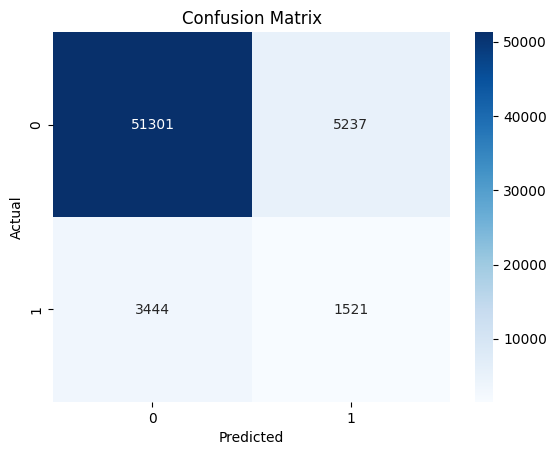

In [36]:
# Get predictions
y_proba_lgbm_tuned = lgbm_tuned.predict_proba(X_val)[:, 1]
y_pred_lgbm_tuned = (y_proba_lgbm_tuned >= 0.15).astype(int) 


print(roc_auc_score(y_val, y_proba_lgbm_tuned))

cm = confusion_matrix(y_val, y_pred_lgbm_tuned)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f"{RESULTS_DIR}\\explainability\\confusion_matrix_lgbm_tuned.png", bbox_inches='tight', )


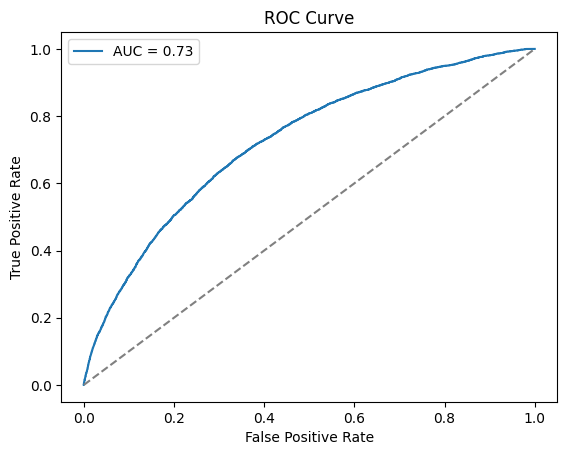

In [37]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_proba_lgbm_tuned)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(f"{RESULTS_DIR}\\explainability\\roc_curve.png", dpi=300, bbox_inches="tight")

### Feature Importance

In [38]:
# Get feature importances from tuned LightGBM model
importance = lgbm_tuned.feature_importances_

feat_imp_df_lgbm = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

feat_imp_df_lgbm.head(30)


,feature,importance
5,age_years,605
24,avg_months_active,570
4,value_of_goods_financed,539
3,monthly_loan_payment,534
21,avg_amt_credit,532
2,total_credit_requested,516
20,avg_amt_applied,475
6,employment_years,469
12,avg_debt_ratio,445
23,n_active_contracts,428


### Save all models

In [39]:
all_models = {
    "log_reg": log_reg_pipe,
    "XGBoost": xgb_tuned,
    "LightGBM": lgbm_tuned,
}

for name, model in all_models.items():
    joblib.dump(model, f"{MODELS_DIR}/{name}.joblib")
